# Feature Extraction from Title

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import string
import pandas as pd
import numpy as np
import re

In [2]:
Drugs = pd.read_csv("Drug Categories.csv")
Drugs.head(10)

,Category,Subcategory,Lookup,Subcategory2
0,Analgesics,Acetimophen,Acetimophen,NaN
1,Analgesics,Carisoprodol,Carisoprodol,NaN
2,Analgesics,Co-codamol,Co-codamol,NaN
3,Analgesics,Co-dydramol,Co-dydramol,NaN
4,Analgesics,Pethidine,Pethidine,NaN
5,Analgesics,Suboxone,Suboxone,NaN
6,Analgesics,Tilidine,Tilidine,NaN
7,Analgesics,Tramadol,Tramadol,NaN
8,Cannabis,Weed,Weed,NaN
9,Cannabis,Weed,Marijuana,NaN


In [4]:
####DATA EXTRACTION FUNCTIONS####

#Find_weight searches the title of a product for a numerical weight and returns if found.
def find_weight(title):
    #Keywords for weight
    words = [" g ","mg", "kg", "ug", "grams", "gr.","g", "gr", "gram", "g.", "gramm", "oz","ounce"]
    
    #Basic cleaning
    s = title.lower() #Set all characters to lowercase
    s= re.sub("[()]","",s) #Remove certain punctuation
    s=s.replace("***"," ") #Replace *** symbol with whitespace
    s=s.replace("..."," ") #Replace *** symbol with whitespace
    s = s.split() #Split the title into tokens
    
    #Searches the title for any of the keywrods
    for word in words:
        #Loops through each token in the title
        for i in range(0,len(s)):
            #If the token equals the keyword:
            if s[i]==word:
                #Try to convert the preceding token into a float (ex. 20 grams)
                try:
                    #Converts all weights to grams
                    if word in ["mg"]: return float(s[i-1].split("-",1)[0])/1000
                    elif word in ["kg"]: return float(s[i-1].split("-",1)[0])*1000
                    elif word in ["ug"]: return float(s[i-1].split("-",1)[0])/1000000
                    elif word in ["oz","ounce"]: return float(s[i-1].split("-",1)[0])*28.3495
                    else: return float(s[i-1].split("-",1)[0])
                #If the preceding token is not a number, continue
                except: continue
            #If the token contains the keyword:
            elif word in s[i]:
                #Try to convert the current token (with the keyword removed) into a float (ex. 200mg)
                try:
                    if word in ["mg"]: return float(s[i].replace(word,"").split("-",1)[0])/1000
                    elif word in ["kg"]: return float(s[i].replace(word,"").split("-",1)[0])*1000
                    elif word in ["ug"]: return float(s[i].replace(word,"").split("-",1)[0])/1000000
                    elif word in ["oz","ounce"]: return float(s[i-1].split("-",1)[0])*28.3495
                    else: return float(s[i].replace(word,"").split("-",1)[0])
                #If the current token is not a number, continue
                except: continue
    #Returns None if no weight can be found
    return None 

#Find_count searches the title of a product for a numerical count and returns if found.
def find_count(title):
    #Keywords for count
    words = ["x", "tabs", "tablets", "capsules", "pills"]
    
    #Basic cleaning
    s = title.lower() #Set all characters to lowercase
    s= re.sub("[()]","",s) #Remove certain punctuation
    s=s.replace("***"," ") #Replace *** symbol with whitespace
    s = s.split() #Split the title into tokens
    
    #Searches the title for any of the keywrods
    for word in words:
        #Loops through each token in the title
        for i in range(0,len(s)):
            #If the token equals the keyword:
            if s[i]==word:
                #Try to convert the preceding token into a float (ex. 20 x pills)
                try: return float(s[i-1].split("-",1)[0])
                #Else to convert the price token into a float (ex. pills x 20)
                except:
                    try: return float(s[i+1].split("-",1)[0])
                    except: continue
            #If the token contains the keyword:
            elif word in s[i]:
                #Try to convert the current token (with the keyword removed) into a float
                try: return float(s[i].replace(word,"").split("-",1)[0])
                except: continue
    
    #If the keyword search fails, try returning the first number found that does not equal the weight.
    for i in range(0,len(s)):
        if s[i].isdigit() and float(s[i])<>find_weight(title): 
            try: return float(s[i])
            except: continue
    
    #If no number can be found, return a count of 1
    return 1 

#Find_category takes a product entry and classifies it into a Category
def find_category(row):
    #Converts the product title to lowercase
    y = str(row["title"]).lower()
    #Loops through a lookup table of known types and their categories
    for i in range(0,len(Drugs["Lookup"])):
        word = Drugs["Lookup"][i] #Pulls the lookup keyword
        word = word.lower() #Converts to lowercase
        
        #If the Lookup word is in the product title, return the Category and Subcategory associated with it
        if word in y: return (Drugs["Subcategory"][i], Drugs["Category"][i])
    
    #Some products have a populated Category, but the classifications are not standard.
    #Some are very specific (equivalent to the title) while other are too generic.
    #Converts product category to lowercase
    y = str(row["category"]).lower()
    #Loops through the same lookup table
    for i in range(0,len(Drugs["Lookup"])): 
        word = Drugs["Lookup"][i]
        word = word.lower()
        #If the Lookup word is in the product category, return the Category and Subcategory associated with it
        if word in y: return (Drugs["Subcategory"][i], Drugs["Category"][i])
        
    #If none of the lookup values are in the Title or the Category, use the original Category as Cat and SubCat
    return (row["category"],row["category"])

#Replace_cutoff replaces outliers from a dataset using an arbitrary cutoff point
def replace_cutoff(df,cutoff):
    outliers = (df - cutoff)>0
    df[outliers] = cutoff
    return df

In [5]:
#Read in raw scraped data
new = pd.read_csv("output.csv")
print new.shape
new.head(10)

(100002, 10)


,title_date,category,date,market,price,price_dollar,ships_from,ships_to,title,vendor
0,2cdcc469ef79378b8daa2accf657dbfd,NaN,10/26/2014 19:00,Silk Road 2,4.3849,1530.2,NaN,NaN,EU Passport 1:1 Good quality,threekings
1,67b9e2d7823f022055171e68f9dc7c81,NaN,8/26/2014 19:00,Silk Road 2,0.015625,7.9755,NaN,NaN,The Walking Dead Seasons 1-4 (AVI),wakeside917
2,9f3552e9f27fda3b83ac8d74e3821829,Alcohol,1/15/2014 18:00,Silk Road 2,0.65731,556.98,PHISHING WARNING:,Confirm that your browser is pointed to our re...,Custom order for foryoumyfr13nd,Alexmack380
3,e2e83eb0a80e26976bfeb700cba54bce,NaN,9/14/2014 19:00,Silk Road 2,4.7957,2260.5,NaN,NaN,250tabs x 250ug LSD ---FREE POSTAGE---,top_gear_uk
4,d394565b83e410c446d7aa847e53c5df,DMT,10/3/2014 19:00,Silk Road 2,0.0231,7.5188,United Kingdom,Worldwide,Breakthrough DMT sample 50mg,9
5,3c1bd1c9b2314d0c21e1178e11955173,NaN,10/10/2014 19:00,Silk Road 2,0.16441,59.055,NaN,NaN,5 Gr of Speed Paste 72%,kriminale
6,c4d4396922c138a512a441c11f73c067,NaN,2/10/2014 18:00,Silk Road 2,0.008896,5.9553,United States,Worldwide,backroomcastingcouch.com Siterip (27GB),wakeside917
7,b99a3fbcec250857b99a79f7caefc1fc,NaN,10/14/2014 19:00,Silk Road 2,0.53248,208.65,NaN,NaN,VIAGRA 10 PACKS OF 4,harrywinston
8,dc9a7e84d7ef868a48a81426e9cfb022,NaN,3/9/2014 19:00,Silk Road 2,0.34441,215.54,Netherlands,Worldwide,50x Green Herbal life 90-120MG MDMA,salt-pepper
9,e196c6fe6fed3b2a750381db36e8fb1d,NaN,4/27/2014 19:00,Silk Road 2,0.94595,413.44,Undeclared,Worldwide,Methenolone Enanthate - 10g - Primobolan,steroid-depot


In [6]:
x,y,a,b = [],[],[],[]

#For each product in the raw data
for i in range(0, new.shape[0]):
    x.append(find_weight(str(new.iloc[i,]["title"]))) #Search for weight
    y.append(find_count(str(new.iloc[i,]["title"])))  #Search for count
    c,d = find_category(new.iloc[i,])                 #Search for Category and SubCategory
    a.append(c)
    b.append(d)
    
new["Weight"]=pd.DataFrame(x)  #Create "Weight" field in data with results of find_weight()
new["Count"]=pd.DataFrame(y)   #Create "Count" field in data with results of find_count()
new["SubCat2"]=pd.DataFrame(a) #Create "SubCat2" field in data with results of find_category()
new["Cat2"]=pd.DataFrame(b)    #Create "Cat2" field in data with results of find_category()

In [10]:
#Show new data
new[["title","Weight","Count","category","Cat2","SubCat2"]]

,title,Weight,Count,category,Cat2,SubCat2
0,EU Passport 1:1 Good quality,NaN,1,NaN,NaN,NaN
1,The Walking Dead Seasons 1-4 (AVI),NaN,1,NaN,NaN,NaN
2,Custom order for foryoumyfr13nd,NaN,1,Alcohol,Other,Alcohol
3,250tabs x 250ug LSD ---FREE POSTAGE---,0.00025,250,NaN,Psychadelics,LSD
4,Breakthrough DMT sample 50mg,0.05000,1,DMT,Psychadelics,DMT
5,5 Gr of Speed Paste 72%,5.00000,1,NaN,Stimulants,Speed
6,backroomcastingcouch.com Siterip (27GB),NaN,1,NaN,NaN,NaN
7,VIAGRA 10 PACKS OF 4,NaN,10,NaN,Sildenafil Citrate,Viagra
8,50x Green Herbal life 90-120MG MDMA,0.09000,50,NaN,Ecstasy,MDMA
9,Methenolone Enanthate - 10g - Primobolan,10.00000,1,NaN,NaN,NaN


In [11]:
new["price_dollar"]=pd.to_numeric(new["price_dollar"],errors='coerce')
new["PPW"] = new["price_dollar"]/new["Weight"]
new["PPWC"] = new["PPW"]/new["Count"]


In [15]:
#Export new data to csv file
new.to_csv("new2.csv",",",index=False)

### Cleaning Outliers

In [16]:
#Read in raw scraped data
new = pd.read_csv("new2.csv")
print new.shape
#new.head(10)

(100002, 16)


12.0012857143
136.830551742
1644.11324177


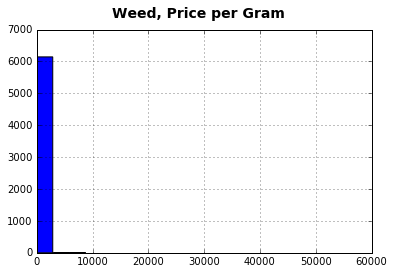

In [17]:
print new[new["SubCat2"]=="Weed"]["PPW"].median()
print new[new["SubCat2"]=="Weed"]["PPW"].mean()
print new[new["SubCat2"]=="Weed"]["PPW"].std()
new[new["SubCat2"]=="Weed"]["PPW"].hist(bins = 20)


plt.suptitle('Weed, Price per Gram', fontsize=14, fontweight='bold')
plt.show()

12.0012857143
16.6266067521
16.8292095438


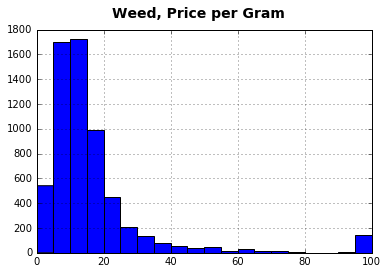

In [18]:
new.ix[new.SubCat2=="Weed", 'PPW'] = replace_cutoff(new.ix[new.SubCat2=="Weed", 'PPW'],100)
print new[new["SubCat2"]=="Weed"]["PPW"].median()
print new[new["SubCat2"]=="Weed"]["PPW"].mean()
print new[new["SubCat2"]=="Weed"]["PPW"].std()
new[new["SubCat2"]=="Weed"]["PPW"].hist(bins = 20)
plt.suptitle('Weed, Price per Gram', fontsize=14, fontweight='bold')
plt.show()

104.231
204.239476061
3024.54437132


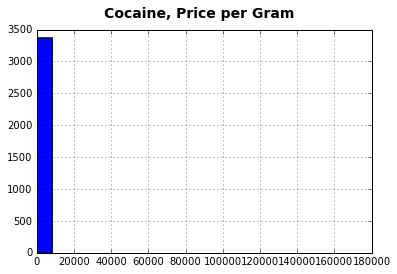

In [19]:
print new[new["SubCat2"]=="Cocaine"]["PPW"].median()
print new[new["SubCat2"]=="Cocaine"]["PPW"].mean()
print new[new["SubCat2"]=="Cocaine"]["PPW"].std()
new[new["SubCat2"]=="Cocaine"]["PPW"].hist(bins = 20)
plt.suptitle('Cocaine, Price per Gram', fontsize=14, fontweight='bold')
plt.show()

104.231
134.326381811
91.7708749134


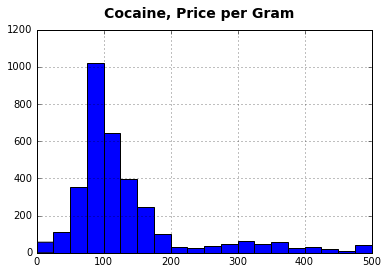

In [20]:
new.ix[new.SubCat2=="Cocaine", 'PPW'] = replace_cutoff(new.ix[new.SubCat2=="Cocaine", 'PPW'],500)
print new[new["SubCat2"]=="Cocaine"]["PPW"].median()
print new[new["SubCat2"]=="Cocaine"]["PPW"].mean()
print new[new["SubCat2"]=="Cocaine"]["PPW"].std()
new[new["SubCat2"]=="Cocaine"]["PPW"].hist(bins = 20)
plt.suptitle('Cocaine, Price per Gram', fontsize=14, fontweight='bold')
plt.show()

7.1627
61.9868012119
436.804332965


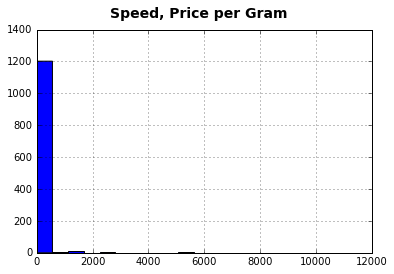

In [21]:
print new[new["SubCat2"]=="Speed"]["PPW"].median()
print new[new["SubCat2"]=="Speed"]["PPW"].mean()
print new[new["SubCat2"]=="Speed"]["PPW"].std()
new[new["SubCat2"]=="Speed"]["PPW"].hist(bins = 20)
plt.suptitle('Speed, Price per Gram', fontsize=14, fontweight='bold')
plt.show()

7.1627
14.7445370997
16.3658059457


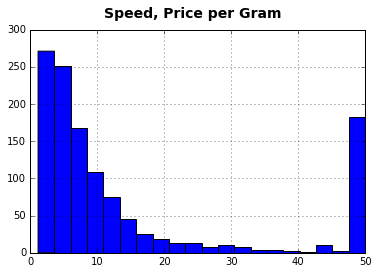

In [22]:
##Still alot above 50. Need to look at incorporating counts##
new.ix[new.SubCat2=="Speed", 'PPW'] = replace_cutoff(new.ix[new.SubCat2=="Speed", 'PPW'],50)
print new[new["SubCat2"]=="Speed"]["PPW"].median()
print new[new["SubCat2"]=="Speed"]["PPW"].mean()
print new[new["SubCat2"]=="Speed"]["PPW"].std()
new[new["SubCat2"]=="Speed"]["PPW"].hist(bins = 20)
plt.suptitle('Speed, Price per Gram', fontsize=14, fontweight='bold')
plt.show()

In [23]:
new[new["SubCat2"]=="Speed"]

,title_date,category,date,market,price,price_dollar,ships_from,ships_to,title,vendor,Weight,Count,SubCat2,Cat2,PPW,PPWC
5,3c1bd1c9b2314d0c21e1178e11955173,NaN,10/10/2014 19:00,Silk Road 2,0.16441,59.0550,NaN,NaN,5 Gr of Speed Paste 72%,kriminale,5.000,1,Speed,Stimulants,11.811000,11.811000
15,489ca84ede13d1787df6fe521ecb97dc,Stimulants,1/15/2014 18:00,Silk Road 2,0.49557,419.9300,PHISHING WARNING:,Confirm that your browser is pointed to our re...,***100 GRAM OF 72% PURE SPEED PASTE***,FASTER-WAYS,100.000,1,Speed,Stimulants,4.199300,4.199300
171,23ca2fb673b28408451f5811e5298ed3,Speed,10/23/2014 19:00,Silk Road 2,0.13026,46.2650,Finland,Finland,1g amfetamiinia Suomesta 35e/g,11,1.000,1,Speed,Stimulants,46.265000,46.265000
196,ac363f77ad149e0942f215ae432e9ac5,NaN,9/19/2014 19:00,Silk Road 2,0.34759,141.4100,NaN,NaN,10g HQ Dutch Speed paste,swissshop,10.000,1,Speed,Stimulants,14.141000,14.141000
271,4832a5f4103f733b2076d981124c9aca,NaN,7/7/2014 19:00,Silk Road 2,0.10187,63.1800,United Kingdom,Worldwide,INTRO OFFER 7G TOP OF THE RAGE SPEED,cornettos,7.000,1,Speed,Stimulants,9.025714,9.025714
393,217800fb91e9d80a479889d655251a78,NaN,10/10/2014 19:00,Silk Road 2,0.42249,151.7600,NaN,NaN,"Amfetamin, ""Speedpaste"" - 5 gram",apoteket,5.000,1,Speed,Stimulants,30.352000,30.352000
394,81ee2f369b4b4b959f406e48ecc07864,NaN,10/31/2014 19:00,Silk Road 2,0.45613,148.4200,NaN,NaN,10g HQ Dutch Speed paste,swissshop,10.000,1,Speed,Stimulants,14.842000,14.842000
570,af401d8987db52d02221568a80c61e2e,NaN,10/26/2014 19:00,Silk Road 2,0.50498,176.2200,NaN,NaN,50g Top Quality Pure Homemade Speedpaste!!!!,dutchcomfort,50.000,1,Speed,Stimulants,3.524400,3.524400
582,f922acafcf3f6711856702675d5ef8c6,NaN,8/26/2014 19:00,Silk Road 2,0.27768,141.7400,NaN,NaN,"Amfetamin, ""Speedpaste"" - 5 gram",apoteket,5.000,1,Speed,Stimulants,28.348000,28.348000
656,e59bb25f240d5af7fd90e7c61fd3e037,NaN,11/4/2014 18:00,Silk Road 2,0.42694,143.9400,NaN,NaN,Omega - Speedmaster Lady Chrono Diamond [Replica],repaaa,NaN,1,Speed,Stimulants,NaN,NaN


58.3895
4105.00593146
23426.3711084


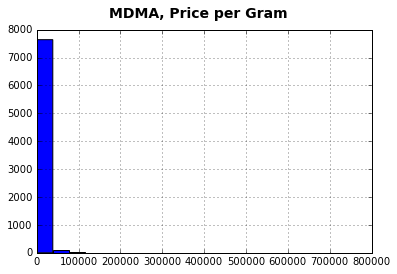

In [24]:
print new[new["SubCat2"]=="MDMA"]["PPW"].median()
print new[new["SubCat2"]=="MDMA"]["PPW"].mean()
print new[new["SubCat2"]=="MDMA"]["PPW"].std()
new[new["SubCat2"]=="MDMA"]["PPW"].hist(bins = 20)
plt.suptitle('MDMA, Price per Gram', fontsize=14, fontweight='bold')
plt.show()

58.3895
104.267844129
83.344731631


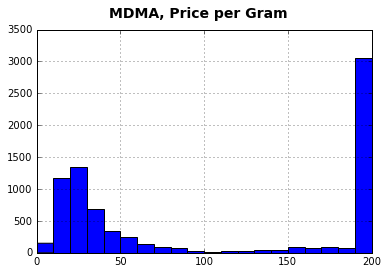

In [25]:
new.ix[new.SubCat2=="MDMA", 'PPW'] = replace_cutoff(new.ix[new.SubCat2=="MDMA", 'PPW'],200)
print new[new["SubCat2"]=="MDMA"]["PPW"].median()
print new[new["SubCat2"]=="MDMA"]["PPW"].mean()
print new[new["SubCat2"]=="MDMA"]["PPW"].std()
new[new["SubCat2"]=="MDMA"]["PPW"].hist(bins = 20)
plt.suptitle('MDMA, Price per Gram', fontsize=14, fontweight='bold')
plt.show()

In [26]:
new[new["SubCat2"]=="MDMA"]

,title_date,category,date,market,price,price_dollar,ships_from,ships_to,title,vendor,Weight,Count,SubCat2,Cat2,PPW,PPWC
8,dc9a7e84d7ef868a48a81426e9cfb022,NaN,3/9/2014 19:00,Silk Road 2,0.34441,215.540,Netherlands,Worldwide,50x Green Herbal life 90-120MG MDMA,salt-pepper,0.09,50,MDMA,Ecstasy,200.000000,47.897778
17,a4852a3e4159b41dbda310c590ab742f,NaN,10/26/2014 19:00,Silk Road 2,8.9736,3131.400,NaN,NaN,1000x Gold Bar 200-220mg MDMA (new Wifi),xtandmd,0.20,1000,MDMA,Ecstasy,200.000000,15.657000
27,58de578604e80de9dfaf01fe297f8402,NaN,9/22/2014 19:00,Silk Road 2,0.53965,234.950,NaN,NaN,"Symbiosis - 7g MDMA, UK First Class",saint-symbiosis,7.00,1,MDMA,Ecstasy,33.564286,33.564286
30,95c4af2c304c8c54cf703fa5965a1e3e,NaN,9/14/2014 19:00,Silk Road 2,0.71343,336.280,NaN,NaN,"14.0g PURE MDMA CRYSTAL, Dutch origin 88% puri...",mirkov,14.00,1,MDMA,Ecstasy,24.020000,24.020000
33,be623ba6bc387f046e44da1c480fcbff,NaN,10/31/2014 19:00,Silk Road 2,0.12385,40.301,NaN,NaN,1g Supreme MDMA 84% - Reagent Tested Straight ...,vendorz,1.00,1,MDMA,Ecstasy,40.301000,40.301000
34,57389170e7cc61310e5dcd4b9f43bfd3,NaN,10/16/2014 19:00,Silk Road 2,0.33486,127.390,NaN,NaN,0.5g MDMA - (5 SINGLE POINT SERVINGS) OF IMPOR...,chemicalbrothers,0.50,5,MDMA,Ecstasy,200.000000,50.956000
35,2c89bfe644dab82cc1030670e4b3af8d,NaN,10/19/2014 19:00,Silk Road 2,1.8851,715.130,NaN,NaN,"Symbiosis - 28g MDMA, UK First Class",saint-symbiosis,28.00,1,MDMA,Ecstasy,25.540357,25.540357
52,081531d9f26b458e6ad9837b0ddad03e,NaN,8/26/2014 19:00,Silk Road 2,0.2354,120.150,NaN,NaN,"25 XTC pills, Red Bugatti 220mg |",holland-dutch,0.22,25,MDMA,Ecstasy,200.000000,21.845455
60,2a5c3b72f4de599c392ee97935bd8420,NaN,8/29/2014 19:00,Silk Road 2,1.8566,930.520,NaN,NaN,50 gr. Pure MDMA Crystals 84% 50 gr. Pure MDM...,transporter,50.00,1,MDMA,Ecstasy,18.610400,18.610400
66,dcb26bf85cbc358407bbcbc7dbc35107,NaN,10/14/2014 19:00,Silk Road 2,2.4577,963.040,NaN,NaN,50gr Dutch MDMA Crystals 83%,goldbar,50.00,1,MDMA,Ecstasy,19.260800,19.260800


27.705
161.247525867
2433.99357646


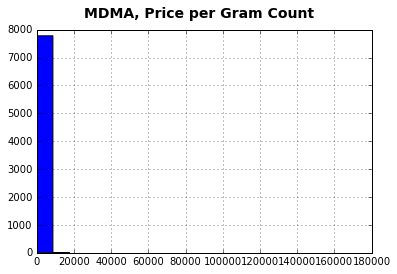

In [29]:
print new[new["SubCat2"]=="MDMA"]["PPWC"].median()
print new[new["SubCat2"]=="MDMA"]["PPWC"].mean()
print new[new["SubCat2"]=="MDMA"]["PPWC"].std()
new[new["SubCat2"]=="MDMA"]["PPWC"].hist(bins = 20)
plt.suptitle('MDMA, Price per Gram Count', fontsize=14, fontweight='bold')
plt.show()

27.705
48.2109731431
51.7390265267


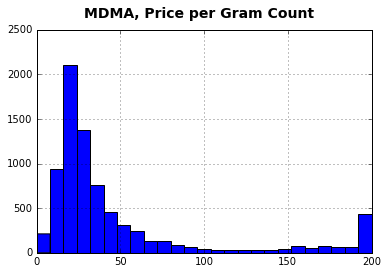

In [40]:
new.ix[new.SubCat2=="MDMA", 'PPWC'] = replace_cutoff(new.ix[new.SubCat2=="MDMA", 'PPWC'],200)
print new[new["SubCat2"]=="MDMA"]["PPWC"].median()
print new[new["SubCat2"]=="MDMA"]["PPWC"].mean()
print new[new["SubCat2"]=="MDMA"]["PPWC"].std()
new[new["SubCat2"]=="MDMA"]["PPWC"].hist(bins = 25)
plt.suptitle('MDMA, Price per Gram Count', fontsize=14, fontweight='bold')
plt.show()